# Neural Web With TensorFlow
This is my firt try using TensorFlow 

In [13]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [14]:


col_names = [
    'Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 
    'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 
    'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points'
]
col_names += [f'Wilderness_Area_{i}' for i in range(4)]
col_names += [f'Soil_Type_{i}' for i in range(1, 41)]
col_names.append('Cover_Type')
file_path = "covtype.data"
data = pd.read_csv(r'C:\Users\Matheus\Desktop\trabalho ia fag\covtype.data', header=None, names=col_names)

print(f"Dataset carregado com sucesso! Formato: {data.shape}") 
print(data.head())


Dataset carregado com sucesso! Formato: (581012, 55)
   Elevation  Aspect  Slope  Horizontal_Distance_To_Hydrology  \
0       2596      51      3                               258   
1       2590      56      2                               212   
2       2804     139      9                               268   
3       2785     155     18                               242   
4       2595      45      2                               153   

   Vertical_Distance_To_Hydrology  Horizontal_Distance_To_Roadways  \
0                               0                              510   
1                              -6                              390   
2                              65                             3180   
3                             118                             3090   
4                              -1                              391   

   Hillshade_9am  Hillshade_Noon  Hillshade_3pm  \
0            221             232            148   
1            220             235 

In [15]:

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
       for gpu in gpus: 
        tf.config.experimental.set_memory_growth(gpu, True)
        print(f"Memory growth ativado para {len(gpus)} GPUs.")
    except RuntimeError as error:
        print("Não foi possível ativar o memory growth, rode este código antes de inicializar o Keras!")
        print(error)







In [16]:
# 1. Separar X e y
X = data.drop('Cover_Type', axis=1)
y = data['Cover_Type'] # y original (classes 1-7)

# 2. Separar em Treino e Teste (80/20)
# AQUI CRIAMOS O y_train
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=42, 
                                                    stratify=y)
print(f"Amostras de Treino: {X_train.shape[0]}, Amostras de Teste: {X_test.shape[0]}")
print("Variáveis 'y_train' e 'y_test' criadas com sucesso.")

Amostras de Treino: 464809, Amostras de Teste: 116203
Variáveis 'y_train' e 'y_test' criadas com sucesso.


In [17]:

quantitative_features = list(X.columns[:10])
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), quantitative_features)
    ],
    remainder='passthrough'
)

X_train_scaled = preprocessor.fit_transform(X_train)
X_test_scaled = preprocessor.transform(X_test)
print(f"Features de treino escaladas. Formato: {X_train_scaled.shape}")

Features de treino escaladas. Formato: (464809, 54)


In [18]:


y_train_keras = y_train - 1 
y_test_keras = y_test - 1 

n_features = X_train.shape[1]
n_classes = len(np.unique(y_train_keras))
print(f"Features: {n_features}, Classes: {n_classes} (0-6)")






Features: 54, Classes: 7 (0-6)


In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

print("\n--- Célula 2: Construindo o modelo Keras ---")
model = Sequential()

# Camada 1 (Entrada + 1ª Oculta)
# 'input_shape' (formato da entrada) é necessário apenas na primeira camada
model.add(Dense(units=100, activation='relu', input_shape=(n_features,)))

# Camada 2 (2ª Oculta)
model.add(Dense(units=50, activation='relu'))

# Camada de Dropout (para prevenir overfitting)
model.add(Dropout(0.2)) # "Desliga" 20% dos neurónios aleatoriamente

# Camada de Saída
# 'softmax' é essencial para classificação multiclasse (dá as probabilidades)
model.add(Dense(units=n_classes, activation='softmax'))

# Ver um resumo da arquitetura
model.summary()



--- Célula 2: Construindo o modelo Keras ---


D:\Programacao\Python\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 100)                 │           5,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 50)                  │           5,050 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 7)                   │             357 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,907 (42.61 KB)

 Trainable params: 10,907 (42.61 KB)

 Non-trainable params: 0 (0.00 B)

In [20]:
model.compile(
    optimizer='adam', # Otimizador padrão e mais eficiente
    loss='sparse_categorical_crossentropy', # A função de erro perfeita para 'y' sendo inteiros (0-6)
    metrics=['accuracy'] # O que queremos que ele reporte
)

In [21]:
history = model.fit(
    X_train_scaled, 
    y_train_keras,
    epochs=50,       # 50 "voltas" completas no dataset (pode ajustar este valor)
    batch_size=64,   # Processa 64 amostras de cada vez antes de atualizar os pesos
    verbose=1,       # Mostra a barra de progresso
    validation_data=(X_test_scaled, y_test_keras) # Avalia no teste a cada época
)

Epoch 1/50
7263/7263 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - accuracy: 0.7601 - loss: 0.5626 - val_accuracy: 0.7963 - val_loss: 0.4762
Epoch 2/50
7263/7263 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.8020 - loss: 0.4627 - val_accuracy: 0.8229 - val_loss: 0.4190
Epoch 3/50
7263/7263 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - accuracy: 0.8169 - loss: 0.4277 - val_accuracy: 0.8321 - val_loss: 0.3937
Epoch 4/50
7263/7263 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.8275 - loss: 0.4051 - val_accuracy: 0.8429 - val_loss: 0.3718
Epoch 5/50
7263/7263 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.8340 - loss: 0.3898 - val_accuracy: 0.8491 - val_loss: 0.3595
Epoch 6/50
7263/7263 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.8390 - loss: 0.3788 - val_accuracy: 0.8531 - val_loss: 0.3470
Epoch 7/50
7263/7263 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.8421 - loss: 0.3703 - val_accuracy: 0.8574 - val_loss: 0.3420
Epoch 8/50
7263/7263 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.8458 - loss: 0


--- Célula 5: Plotando histórico de treino ---


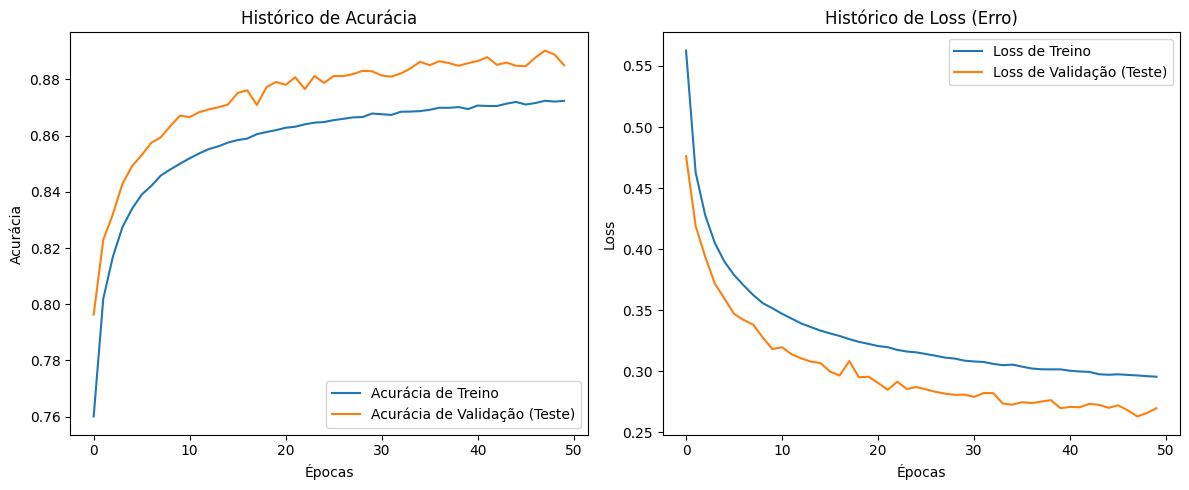

In [22]:
print("\n--- Célula 5: Plotando histórico de treino ---")

# Plotar Acurácia
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Acurácia de Treino')
plt.plot(history.history['val_accuracy'], label='Acurácia de Validação (Teste)')
plt.title('Histórico de Acurácia')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend()

# Plotar Loss (Erro)
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Loss de Treino')
plt.plot(history.history['val_loss'], label='Loss de Validação (Teste)')
plt.title('Histórico de Loss (Erro)')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout() # Ajusta o layout para não sobrepor
plt.show()


--- Célula 6: Avaliação final no conjunto de teste ---
3632/3632 ━━━━━━━━━━━━━━━━━━━━ 3s 797us/step
Acurácia Final do Modelo Keras: 0.8850

Relatório de Classificação (Keras):
              precision    recall  f1-score   support

           0       0.94      0.82      0.87     42368
           1       0.87      0.95      0.91     56661
           2       0.83      0.92      0.87      7151
           3       0.75      0.80      0.78       549
           4       0.79      0.67      0.73      1899
           5       0.80      0.69      0.74      3473
           6       0.92      0.91      0.91      4102

    accuracy                           0.89    116203
   macro avg       0.84      0.82      0.83    116203
weighted avg       0.89      0.89      0.88    116203



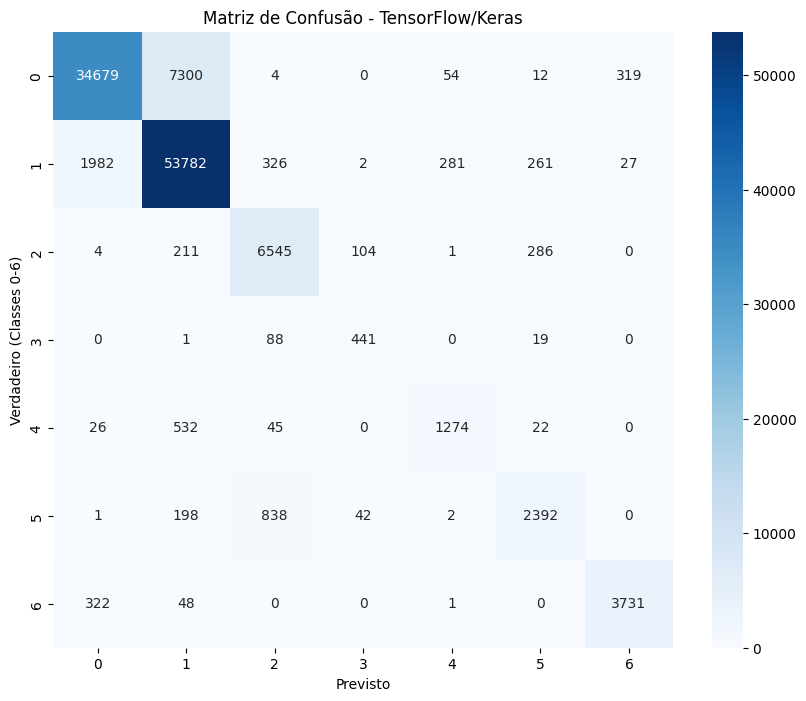

In [23]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

print("\n--- Célula 6: Avaliação final no conjunto de teste ---")

# 1. Fazer as previsões (retorna probabilidades)
y_pred_probs = model.predict(X_test_scaled)

# 2. Converter probabilidades na classe prevista (0-6)
#    (np.argmax encontra o *índice* da maior probabilidade em cada linha)
y_pred_keras = np.argmax(y_pred_probs, axis=1)

# 3. Calcular acurácia final
acc_final = accuracy_score(y_test_keras, y_pred_keras)
print(f"Acurácia Final do Modelo Keras: {acc_final:.4f}")

# 4. Relatório de classificação
print("\nRelatório de Classificação (Keras):")
print(classification_report(y_test_keras, y_pred_keras))

# 5. Plotar Matriz de Confusão
cm_keras = confusion_matrix(y_test_keras, y_pred_keras)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_keras, annot=True, fmt='d', cmap='Blues', 
            xticklabels=range(n_classes), yticklabels=range(n_classes))
plt.xlabel('Previsto')
plt.ylabel('Verdadeiro (Classes 0-6)')
plt.title('Matriz de Confusão - TensorFlow/Keras')
plt.show()